In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import random

# Подготовка данных

In [2]:
df = pd.read_csv('AAPL.csv') #данные по AAPL за 2020 год (из папки 2021)

In [3]:
close = df['close']

In [4]:
df['l_close'] = np.log(close)

In [5]:
df['d_l_close'] = np.zeros(101676)
for i in range(0,101675):
    df['d_l_close'][i+1] = df['l_close'][i+1] - df['l_close'][i]

C:\Users\dasha\AppData\Local\Temp/ipykernel_2440/2266615516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['d_l_close'][i+1] = df['l_close'][i+1] - df['l_close'][i]


# ARIMA

Параметры подбирались с помощью обучения на всем 2020 году в R через auto.arima и критерий Шварца, после чего в цикле для предсказания цен на 10 дней она каждый раз переподбирала их, но в Python обучить ее таким образом не удалось - не хватило памяти даже для одного обучения на всем датафрейме, поэтому пришлось обрезать датасет и взять изначальные параметры из первой модели в R - эту проблему еще предстоит решить. \
\
Пути решения: 
1. Найти autoarima в python для подбора параметров, либо сделать цикл для подбора
2. Чтобы считать на больших датасетах, проходиться по всему датасету, но учить модель на небольшом окне

https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

In [6]:
from statsmodels.tsa.arima_model import ARIMA

In [7]:
df_short = df[101000:101676]

In [8]:
df_short

,date,open,high,low,close,volume,vwap,timestamp,transactions,otc,l_close,d_l_close
101000,2020-12-30 11:16:00-05:00,134.5005,134.730,134.5000,134.7200,409048.0,134.6400,1609344960000,2691,NaN,4.903199,0.001565
101001,2020-12-30 11:17:00-05:00,134.7300,134.765,134.6701,134.7200,265185.0,134.7204,1609345020000,1692,NaN,4.903199,0.000000
101002,2020-12-30 11:18:00-05:00,134.7146,134.750,134.6200,134.6400,242928.0,134.6897,1609345080000,1495,NaN,4.902605,-0.000594
101003,2020-12-30 11:19:00-05:00,134.6493,134.750,134.6000,134.6940,193919.0,134.6859,1609345140000,1423,NaN,4.903006,0.000401
101004,2020-12-30 11:20:00-05:00,134.6800,134.710,134.6000,134.6585,162046.0,134.6541,1609345200000,1096,NaN,4.902742,-0.000264
...,...,...,...,...,...,...,...,...,...,...,...,...
101671,2020-12-31 15:56:00-05:00,132.6500,132.820,132.6500,132.7693,513816.0,132.7459,1609448160000,3191,NaN,4.888613,0.000974
101672,2020-12-31 15:57:00-05:00,132.7700,132.920,132.7600,132.8408,505929.0,132.8310,1609448220000,3527,NaN,4.889151,0.000538
101673,2020-12-31 15:58:00-05:00,132.8400,132.920,132.8300,132.8600,517398.0,132.8745,1609448280000,3472,NaN,4.889296,0.000145
101674,2020-12-31 15:59:00-05:00,132.8650,133.000,132.5500,132.5800,1698250.0,132.8086,1609448340000,8187,NaN,4.887186,-0.002110


In [9]:
random.seed(42)
j = 0
forecasts = []
for i in range(666, 676):
    arima_model = ARIMA(df_short['l_close'][0:i], order = (2,1,2))
    model = arima_model.fit()
    forecasts.append(float(model.forecast(1)[0]))

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn

In [10]:
fact = df_short['l_close'][666:676]

In [11]:
fact = fact.to_list()

In [12]:
fact_vs_fcst = pd.DataFrame(columns=(['fct','fcst']))

In [13]:
fact_vs_fcst['fct'] = np.exp(fact)

In [14]:
fact_vs_fcst['fcst'] = np.exp(forecasts)

In [15]:
fact_vs_fcst

,fct,fcst
0,132.9900,133.144830
1,133.1750,132.961279
2,133.1800,133.150537
3,132.5900,133.163084
4,132.6400,132.615447
5,132.7693,132.665713
6,132.8408,132.768785
7,132.8600,132.837252
8,132.5800,132.849662
9,132.8000,132.592372


Для этих же значений в R с автоподбором параметров на каждой итерации для всей выборки я получила такую таблицу:
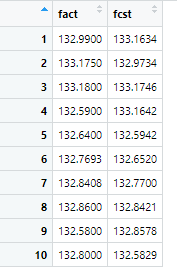

In [16]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(np.exp(fact), np.exp(forecasts))

0.0012588559533750741

In [17]:
from sklearn.metrics import r2_score
r2_score(np.exp(fact), np.exp(forecasts)) #очевидно, что расчет R^2 в чистом виде не совсем подходит для этой модели

-0.24439459905813488

In [18]:
from scipy import stats
stats.spearmanr(np.exp(fact), np.exp(forecasts))

SpearmanrResult(correlation=0.2727272727272727, pvalue=0.44583834154275137)

# ARMA&GARCH 

Параметры для ARMA взяты такие же, как для ARIMA, параметры для GARCH выбраны рандомно.

https://github.com/iankhr/armagarch

In [19]:
#!pip install armagarch

In [20]:
import armagarch as ag

In [21]:
meanMdl = ag.ARMA(order = {'AR':2,'MA':2})
volMdl = ag.garch(order = {'p':1,'q':1})
distMdl = ag.normalDist()

In [22]:
random.seed(42)
j = 0
ag_forecasts = []
for i in range(665, 675):
    ag_model = ag.empModel(df_short['d_l_close'][0:i].to_frame(), meanMdl, volMdl, distMdl)
    ag_model.fit()
    ag_forecasts.append(float(ag_model.predict(1)[0]))

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn

                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                            0.0
Mean Model:                                          ARMA    Adj. R-squared:                                     -0.01
Vol Model:                                          GARCH    Log Likelihood:                                   3551.09
Distribution:                                    Gaussian    AIC:                                             -7086.18
Method:                                                ML    BIC:                                             -7050.19
                                                             Num obs:                                              665
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         658
Time:                                         

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                            0.0
Mean Model:                                          ARMA    Adj. R-squared:                                     -0.01
Vol Model:                                          GARCH    Log Likelihood:                                   3531.31
Distribution:                                    Gaussian    AIC:                                             -7046.62
Method:                                                ML    BIC:                                             -7010.61
                                                             Num obs:                                              666
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         659
Time:                                         

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                           0.01
Mean Model:                                          ARMA    Adj. R-squared:                                      -0.0
Vol Model:                                          GARCH    Log Likelihood:                                   3534.58
Distribution:                                    Gaussian    AIC:                                             -7053.15
Method:                                                ML    BIC:                                             -7017.13
                                                             Num obs:                                              667
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         660
Time:                                         

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                            0.0
Mean Model:                                          ARMA    Adj. R-squared:                                     -0.01
Vol Model:                                          GARCH    Log Likelihood:                                   3537.47
Distribution:                                    Gaussian    AIC:                                             -7058.94
Method:                                                ML    BIC:                                              -7022.9
                                                             Num obs:                                              668
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         661
Time:                                         

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                            0.0
Mean Model:                                          ARMA    Adj. R-squared:                                     -0.01
Vol Model:                                          GARCH    Log Likelihood:                                   3543.08
Distribution:                                    Gaussian    AIC:                                             -7070.17
Method:                                                ML    BIC:                                             -7034.12
                                                             Num obs:                                              669
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         662
Time:                                         

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                           0.01
Mean Model:                                          ARMA    Adj. R-squared:                                       0.0
Vol Model:                                          GARCH    Log Likelihood:                                   3523.63
Distribution:                                    Gaussian    AIC:                                             -7031.26
Method:                                                ML    BIC:                                              -6995.2
                                                             Num obs:                                              670
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         663
Time:                                         

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                           0.01
Mean Model:                                          ARMA    Adj. R-squared:                                      -0.0
Vol Model:                                          GARCH    Log Likelihood:                                   3528.75
Distribution:                                    Gaussian    AIC:                                             -7041.51
Method:                                                ML    BIC:                                             -7005.44
                                                             Num obs:                                              671
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         664
Time:                                         

C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\dasha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                                             ARMA-GARCH estimation results                                              
Dep Variable:                                   d_l_close    R-squared:                                           0.02
Mean Model:                                          ARMA    Adj. R-squared:                                      0.01
Vol Model:                                          GARCH    Log Likelihood:                                   3533.31
Distribution:                                    Gaussian    AIC:                                             -7050.62
Method:                                                ML    BIC:                                             -7014.53
                                                             Num obs:                                              672
Date:                                    Sat, Oct 08 2022    Df Residuals:                                         665
Time:                                         

In [23]:
prev = (df_short['l_close'][666:676]).to_list()

In [24]:
ag_forecasts_full = []
for i,j in zip(prev, ag_forecasts):
    pred = i + j 
    ag_forecasts_full.append(pred)

In [25]:
fact_vs_fcst_ag = pd.DataFrame(columns=(['fct','fcst']))

In [26]:
fact_vs_fcst_ag['fct'] = np.exp(fact)

In [27]:
fact_vs_fcst_ag['fcst'] = np.exp(ag_forecasts_full)

In [28]:
fact_vs_fcst_ag

,fct,fcst
0,132.9900,132.987358
1,133.1750,133.158736
2,133.1800,133.156298
3,132.5900,132.580264
4,132.6400,132.632315
5,132.7693,132.800303
6,132.8408,132.867157
7,132.8600,132.857951
8,132.5800,132.575772
9,132.8000,132.787597


Для этих же значений в R на полной выборке с использование ugarchspec 'sGARCH' получено:
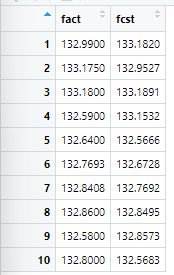

In [29]:
mean_absolute_percentage_error(np.exp(fact), np.exp(ag_forecasts_full))

0.0001023956683987325

In [30]:
r2_score(np.exp(fact), np.exp(ag_forecasts_full))

0.9934038581732223

In [31]:
stats.spearmanr(np.exp(fact), np.exp(ag_forecasts_full))

SpearmanrResult(correlation=0.9636363636363635, pvalue=7.320974809529922e-06)

# State Space Model

Написана в R, но я не успела разобраться во внутренней архитектуре данных там, поэтому она с ошибками, и не успела найти как переписать ее на питон, смогу сделать позже.